In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt

Tensorflow version: 2.16.1


In [2]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='uniform',
                                              trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='uniform',
                                           trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:, :, :4], axis=-1)
        time_linear = self.weights_linear * x + self.bias_linear  # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1)  # Add dimension (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1)  # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1)  # shape = (batch, seq_len, 2)

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [3]:
class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

        self.key = Dense(self.d_k,
                         input_shape=input_shape,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='glorot_uniform')

        self.value = Dense(self.d_v,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x / np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out


In [4]:
class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

            # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
        self.linear = Dense(input_shape[0][-1],
                            input_shape=input_shape,
                            kernel_initializer='glorot_uniform',
                            bias_initializer='glorot_uniform')

    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear

In [5]:
class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
        self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'attn_heads': self.attn_heads,
                       'dropout_rate': self.dropout_rate})
        return config


In [6]:
from datetime import datetime
tsmc_data = pd.read_csv('./tsmc_stock_prices_INT_close_only.csv')
tsmc_data.index = tsmc_data["date"]
tsmc_data = tsmc_data.drop(columns=["date"])
print(tsmc_data.head())

          close
date           
20100104     64
20100105     64
20100106     64
20100107     64
20100108     64


In [8]:
from sklearn.preprocessing import MinMaxScaler
input_length = 30
output_length = 1
test_percentage = 0.2
dataset = tsmc_data['close'].to_numpy()

scaler = MinMaxScaler()
dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list = []
for i in range(len(dataset) - input_length - output_length):
    dataset_list.append(dataset_norm[i:i + input_length + output_length])
dataset_list = np.array(dataset_list)
trainset = dataset_list[:int(len(dataset_list) * (1 - test_percentage))]
testset = dataset_list[int(len(dataset_list) * (1 - test_percentage)):]

x_train = trainset[:, :-1]
y_train = trainset[:, -1:]
x_test = testset[:, :-1]
y_test = testset[:, -1:]

print('x_train.shape:' + str(x_train.shape))
print('y_train.shape:' + str(y_train.shape))
print('x_test.shape:' + str(x_test.shape))
print('y_test.shape' + str(y_test.shape))

x_train.shape:(2718, 30)
y_train.shape:(2718, 1)
x_test.shape:(680, 30)
y_test.shape(680, 1)


In [9]:
batch_size = 256
seq_len = 30

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [10]:
time_embedding_c = Time2Vector(seq_len)
attn_layer1_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
attn_layer2_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
attn_layer3_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

in_seq_c = Input(shape=(seq_len, 1))
x_c = time_embedding_c(in_seq_c)
x_c = Concatenate(axis=-1)([in_seq_c, x_c])
x_c = attn_layer1_c((x_c, x_c, x_c))
x_c = attn_layer2_c((x_c, x_c, x_c))
x_c = attn_layer3_c((x_c, x_c, x_c))
x_c = GlobalAveragePooling1D(data_format='channels_first')(x_c)
x_c = Dropout(0.1)(x_c)
x_c = Dense(64, activation='relu')(x_c)
x_c = Dropout(0.1)(x_c)
out_c = Dense(1, activation='linear')(x_c)

model = Model(inputs=[in_seq_c], outputs=[out_c])

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])

print(model.summary())

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\normalization\layer_normalization.py:122: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 30, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time2_vector (Time2Vector)    │ (None, 30, 2)             │             120 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 30, 3)             │               0 │ input_layer[0][0],         │
│                               │                           │                 │ time2_vector[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder           │ (None, 30, 3)             │          47,890 │ concatenate[0][0],         │
│ (TransformerEncoder)          │                           │                 │ concatenate[0][0],         │
│                               │                           │                 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder_1         │ (None, 30, 3)             │          47,890 │ transformer_encoder[0][0], │
│ (TransformerEncoder)          │                           │                 │ transformer_encoder[0][0], │
│                               │                           │                 │ transformer_encoder[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder_2         │ (None, 30, 3)             │          47,890 │ transformer_encoder_1[0][… │
│ (TransformerEncoder)          │                           │                 │ transformer_encoder_1[0][… │
│                               │                           │                 │ transformer_encoder_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d      │ (None, 30)                │               0 │ transformer_encoder_2[0][… │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 30)                │               0 │ global_average_pooling1d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_111 (Dense)             │ (None, 64)                │           1,984 │ dropout_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 64)                │               0 │ dense_111[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_112 (Dense)             │ (None, 1)                 │              65 │ dropout_7[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 145,839 (569.68 KB)

 Trainable params: 145,839 (569.68 KB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
history = model.fit([x_train],[y_train],
                    batch_size=batch_size,
                    epochs=10)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 45s 793ms/step - loss: 0.0623 - mae: 0.1765 - mape: 99.8883
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 794ms/step - loss: 0.0402 - mae: 0.1326 - mape: 183.2031
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 784ms/step - loss: 0.0228 - mae: 0.0936 - mape: 264.3794
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 790ms/step - loss: 0.0086 - mae: 0.0610 - mape: 206.7535
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 777ms/step - loss: 0.0043 - mae: 0.0397 - mape: 78.2235
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 776ms/step - loss: 0.0018 - mae: 0.0303 - mape: 94.8448
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 798ms/step - loss: 0.0014 - mae: 0.0263 - mape: 56.8254
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 791ms/step - loss: 0.0015 - mae: 0.0264 - mape: 51.2094
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 786ms/step - loss: 0.0012 - mae: 0.0244 - mape: 53.2436
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 782ms/step - loss: 0.0012 - mae: 0.0236 - mape: 49.2481


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step


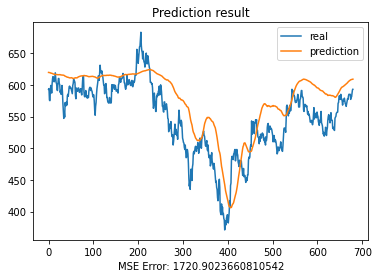

In [13]:
from sklearn.metrics import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()